In [259]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Ignore User Warning regarding Shapely
import matplotlib.pyplot as plt
import contextily
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tobler.model import glm
from tobler.area_weighted import area_interpolate
import os

# Rasterio Installation bug where the Environment variable 'PROJ_LIB' isn't looking in the right file for 'Proj.db' SQLlite Database
# After installation, you need to find the folder where rasterio is storing the 'Proj.db' file
os.environ['PROJ_LIB'] = '/Users/ahadhussain/opt/anaconda3/lib/python3.9/site-packages/rasterio/proj_data/'

gdf = gpd.read_file('NJ City Shapefiles/cb_2018_34_cousub_500k.shp')
# Convert county FIPS codes to str
gdf['COUSUBNS'] = gdf['COUSUBNS'].astype(str)

In [260]:
gdf.shape

(565, 11)

In [261]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [262]:
gdf.dtypes

STATEFP       object
COUNTYFP      object
COUSUBFP      object
COUSUBNS      object
AFFGEOID      object
GEOID         object
NAME          object
LSAD          object
ALAND          int64
AWATER         int64
geometry    geometry
dtype: object

In [263]:
# Specify columns of interest
gdf = gdf[['COUSUBFP','NAME','geometry']]
gdf.head()

,COUSUBFP,NAME,geometry
0,63850,Robbinsville,"POLYGON ((-74.64994 40.24176, -74.62104 40.249..."
1,67350,Shrewsbury,"POLYGON ((-74.07491 40.33727, -74.06909 40.337..."
2,34530,Island Heights,"POLYGON ((-74.15572 39.94746, -74.15372 39.947..."
3,83050,Wyckoff,"POLYGON ((-74.19029 40.99239, -74.18882 41.004..."
4,64410,Roosevelt,"POLYGON ((-74.48993 40.21676, -74.48472 40.220..."


In [264]:
FIPS = pd.read_csv('NJ_FIPS_codes.csv', header=None)

In [265]:
FIPS.head()

,0,1,2,3,4,5,6
0,NJ,34,1,Atlantic County,0,County subdivisions not defined,F
1,NJ,34,1,Atlantic County,100,Absecon city,F
2,NJ,34,1,Atlantic County,2080,Atlantic City city,F
3,NJ,34,1,Atlantic County,7810,Brigantine city,F
4,NJ,34,1,Atlantic County,8680,Buena borough,F


In [266]:
# Drop County subdivisions not defined
FIPS = FIPS[FIPS[5] != 'County subdivisions not defined']

# Select Columns of interest
FIPS = FIPS[[3,4,5]]

FIPS.head()

,3,4,5
1,Atlantic County,100,Absecon city
2,Atlantic County,2080,Atlantic City city
3,Atlantic County,7810,Brigantine city
4,Atlantic County,8680,Buena borough
5,Atlantic County,8710,Buena Vista township


In [267]:
FIPS.shape

(566, 3)

In [268]:
FIPS.dtypes

3    object
4     int64
5    object
dtype: object

In [269]:
# Rename columns
FIPS = FIPS.rename(columns={3:'County', 4: 'COUSUBFP', 5: 'City'})

# Convert COUSUBNS to string and pad with zeroes

FIPS['COUSUBFP'] = FIPS['COUSUBFP'].astype(str)

FIPS['COUSUBFP'] = FIPS['COUSUBFP'].apply(lambda x: x.zfill(5)).astype(str)

# Make City in Title Format

# Remove Repeated Word 'city' from City Column
FIPS['City'] = FIPS['City'].str.split(' city',expand=False)
FIPS['City'] = FIPS['City'].apply(lambda x: x[0])

FIPS['City'] = FIPS['City'].str.title()

FIPS.head()

,County,COUSUBFP,City
1,Atlantic County,00100,Absecon
2,Atlantic County,02080,Atlantic City
3,Atlantic County,07810,Brigantine
4,Atlantic County,08680,Buena Borough
5,Atlantic County,08710,Buena Vista Township


In [270]:
merge = FIPS.merge(gdf,how='inner',on='COUSUBFP')

# Drop NAME and COUSUBFP columns
merge.drop(['NAME','COUSUBFP'],axis=1,inplace=True)

# Add State Column
merge['State'] = 'New Jersey'

# Rearrange Columns

merge = merge[['State','County','City','geometry']]

In [271]:
merge.head()

,State,County,City,geometry
0,New Jersey,Atlantic County,Absecon,"POLYGON ((-74.53138 39.42627, -74.52287 39.435..."
1,New Jersey,Atlantic County,Atlantic City,"POLYGON ((-74.49956 39.35965, -74.49366 39.364..."
2,New Jersey,Atlantic County,Brigantine,"POLYGON ((-74.42199 39.38523, -74.41318 39.389..."
3,New Jersey,Atlantic County,Buena Borough,"POLYGON ((-74.98527 39.51497, -74.95626 39.540..."
4,New Jersey,Atlantic County,Buena Vista Township,"POLYGON ((-74.97183 39.50916, -74.94928 39.508..."


In [272]:
import pymssql

database = "Pushing-P-DB"
table = "dbo.Master_Table"
user = "pushing_p"
password  = "t3stP@ssword"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"


# Retrieve Training Data for Geographically Weighted Regression Model
conn = pymssql.connect(server, user, password, database)


# Query select all rows from SQL table to insert in DataFrame
query = f'SELECT * FROM {table}'
master_table = pd.read_sql(query, conn)
master_table.head()

,State,County,City,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Latitude,Longitude
0,New Jersey,Bergen County,Ramsey Borough,2.3,156058,14915,259,11,11,0,...,159,100,199,4,0,4,0,52,41.062513,-74.135741
1,New Jersey,Monmouth County,Middletown Township,5.6,119013,65168,1821,21,88,191,...,1143,678,1326,225,46,119,0,0,40.392780,-74.099818
2,New Jersey,Hunterdon County,Union Township,4.1,109577,4726,53,0,7,0,...,19,34,37,0,0,0,0,16,40.629903,-74.969181
3,New Jersey,Essex County,Maplewood Township,5.4,149568,25129,974,0,74,335,...,354,620,80,821,24,0,0,42,40.729979,-74.271992
4,New Jersey,Bergen County,Ridgefield Borough,6.2,79696,11209,1525,85,145,85,...,684,841,802,2,3,673,0,20,40.834267,-74.008750


In [273]:
# Merge Geodata with Master_table

df = master_table.merge(merge[['City','geometry']],how='inner',on=['City'])

# Convert to Geodataframe
df = gpd.GeoDataFrame(df, geometry=df['geometry'])

# Add % Uninsured Column
df['% Uninsured'] = df['Uninsured Population']/df['City Population']*100

df.head()

,State,County,City,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Latitude,Longitude,geometry,% Uninsured
0,New Jersey,Bergen County,Ramsey Borough,2.3,156058,14915,259,11,11,0,...,199,4,0,4,0,52,41.062513,-74.135741,"POLYGON ((-74.17616 41.05181, -74.17315 41.054...",1.736507
1,New Jersey,Monmouth County,Middletown Township,5.6,119013,65168,1821,21,88,191,...,1326,225,46,119,0,0,40.392780,-74.099818,"MULTIPOLYGON (((-74.02076 40.47522, -74.01838 ...",2.794316
2,New Jersey,Hunterdon County,Union Township,4.1,109577,4726,53,0,7,0,...,37,0,0,0,0,16,40.629903,-74.969181,"POLYGON ((-75.04588 40.63111, -74.97916 40.657...",1.121456
3,New Jersey,Hunterdon County,Union Township,4.1,109577,4726,53,0,7,0,...,37,0,0,0,0,16,40.629903,-74.969181,"POLYGON ((-74.31176 40.69007, -74.30893 40.690...",1.121456
4,New Jersey,Union County,Union Township,5.2,95489,58355,3879,45,339,583,...,1379,1106,0,311,0,835,40.697590,-74.263163,"POLYGON ((-75.04588 40.63111, -74.97916 40.657...",6.647245


In [274]:
# Read in Census Tract Shape files
tract = gpd.read_file('NJ Census Tract Shapefiles/cb_2018_34_tract_500k.shp')
tract.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,34,023,004700,1400000US34023004700,34023004700,47,CT,648594,0,"POLYGON ((-74.29005 40.52265, -74.28748 40.521..."
1,34,023,006103,1400000US34023006103,34023006103,61.03,CT,2845215,9920,"POLYGON ((-74.49146 40.45320, -74.48557 40.457..."
2,34,023,006500,1400000US34023006500,34023006500,65,CT,5178980,530,"POLYGON ((-74.42388 40.44648, -74.42045 40.445..."
3,34,029,715902,1400000US34029715902,34029715902,7159.02,CT,3377179,201835,"POLYGON ((-74.19763 40.04472, -74.19664 40.050..."
4,34,029,721000,1400000US34029721000,34029721000,7210,CT,2260503,240040,"POLYGON ((-74.33147 40.02096, -74.32669 40.021..."


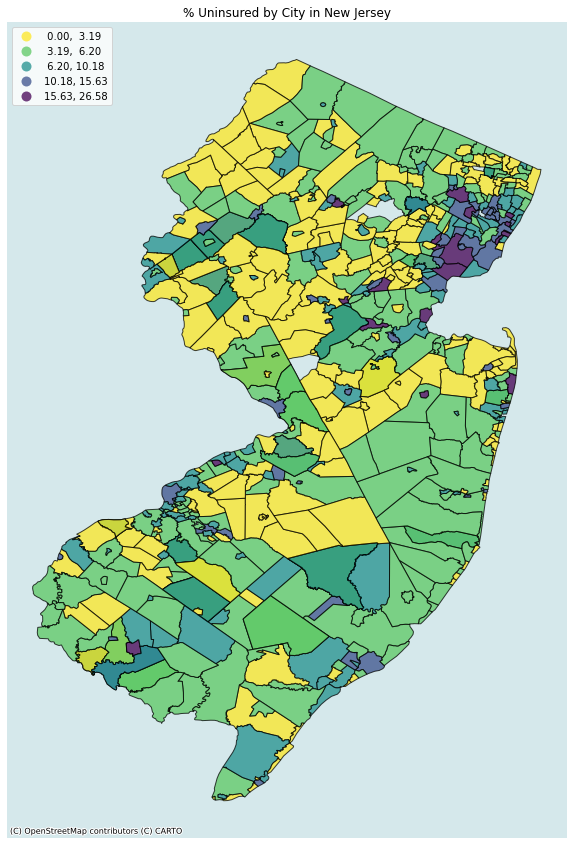

In [275]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
df.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme='natural_breaks',
    k=5, 
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Voyager,
)

plt.title('% Uninsured by City in New Jersey')
ax.set_axis_off();

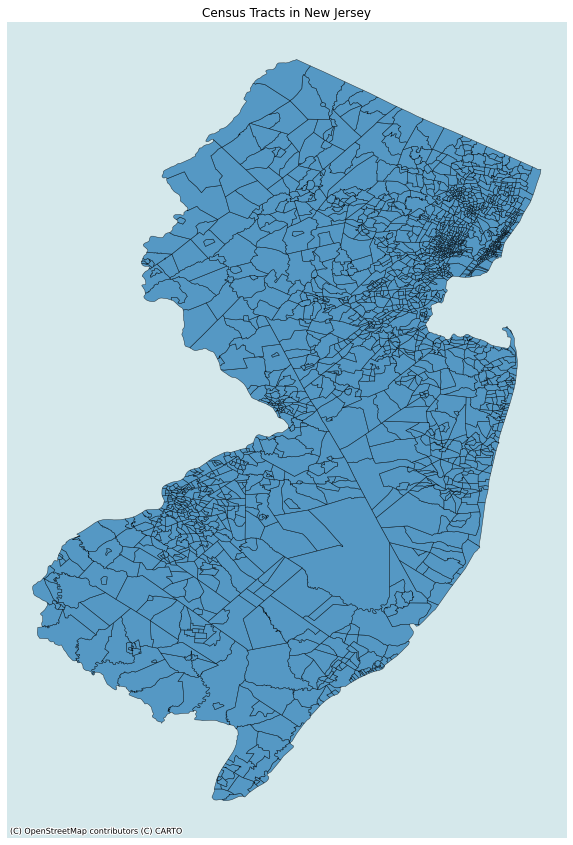

In [276]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
tract.plot(
    edgecolor='black',
    alpha = 0.7,
    ax = ax,
    linewidth = 0.5
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Voyager,
)

plt.title('Census Tracts in New Jersey')
ax.set_axis_off();

In [277]:
# Set df to the same Coordinate System as Tract
df = df.set_crs(tract.crs)

In [278]:
extensive_variables = list(df.drop(['State','County','City','Latitude','Longitude','geometry','% Uninsured'], axis=1).columns)
results = area_interpolate(source_df=df, target_df=tract, intensive_variables = ['Unemployment Rate (16 & Over)'],extensive_variables=extensive_variables)

In [279]:
results.head()

,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Unemployment Rate (16 & Over),geometry
0,0.312579,2528.061161,2387.120865,473.066734,17.215150,58.830094,80.803904,103.850745,84.396225,81.177132,...,245.304229,227.762504,317.943766,17.914953,0.839763,2.519290,0.0,93.540316,6.7,"POLYGON ((-74.29005 40.52265, -74.28748 40.521..."
1,0.502559,8801.247318,3661.861648,200.574963,8.166587,14.089606,12.563980,43.255988,57.166108,31.679178,...,109.755338,90.819625,59.499419,48.281579,2.153825,38.409881,0.0,45.679041,5.6,"POLYGON ((-74.49146 40.45320, -74.48557 40.457..."
2,0.544643,10971.253008,4262.144026,166.250046,2.767858,9.017860,16.607147,36.428581,26.339293,26.160721,...,82.321451,83.928594,68.303590,8.214288,0.000000,66.339304,0.0,19.732148,6.1,"POLYGON ((-74.42388 40.44648, -74.42045 40.445..."
3,0.369692,2898.499246,5711.362268,335.647647,13.187537,19.091581,54.460665,87.512275,84.643020,50.929275,...,165.699471,169.948176,212.159330,19.257115,0.000000,4.193526,0.0,94.961302,6.7,"POLYGON ((-74.19763 40.04472, -74.19664 40.050..."
4,6.062805,68592.815701,2614.829128,223.932637,67.473153,0.000000,10.756590,22.491051,37.159127,62.583794,...,132.990561,90.942075,172.105433,17.601692,0.000000,24.446794,0.0,0.000000,6.2,"POLYGON ((-74.33147 40.02096, -74.32669 40.021..."


In [280]:
results.shape

(2006, 22)

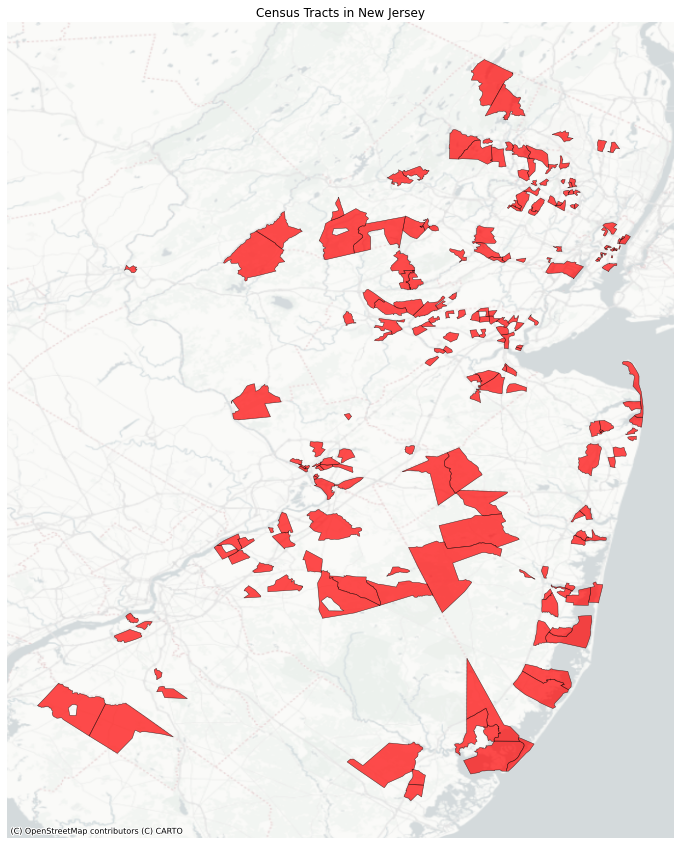

In [297]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
results.iloc[1000:1200].plot(
    color = 'red',
    edgecolor='black',
    alpha = 0.7,
    ax = ax,
    linewidth = 0.5
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.PositronNoLabels,
    crs=results.crs
)

plt.title('Census Tracts in New Jersey')
ax.set_axis_off();

In [304]:
results.iloc[1000:1200]

,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Unemployment Rate (16 & Over),geometry
1000,0.400537,3239.450376,3058.849882,606.186366,22.059445,75.384715,103.541892,133.074048,108.145082,104.020146,...,314.332141,291.854225,407.412237,22.956170,1.076070,3.228211,0.0,119.862294,6.700000,"POLYGON ((-74.27109 40.51490, -74.27100 40.515..."
1001,0.300748,2432.379892,2296.773860,455.162252,16.563597,56.603511,77.745663,99.920234,81.202023,78.104765,...,236.020032,219.142220,305.910330,17.236914,0.807980,2.423941,0.0,90.000031,6.700000,"POLYGON ((-74.27418 40.50856, -74.27254 40.511..."
1002,1.665234,35527.255005,2216.583069,56.461853,0.000000,2.341736,0.000000,11.968872,33.304688,2.341736,...,43.452209,13.009644,54.380310,0.000000,0.000000,0.000000,0.0,0.000000,6.400000,"POLYGON ((-74.53436 40.66731, -74.53328 40.667..."
1003,0.368224,9260.451476,1905.820903,71.916352,2.329579,2.404727,3.757385,12.925405,16.607642,23.821822,...,37.573852,34.342500,56.435925,3.682237,0.000000,7.063884,0.0,4.208271,4.900000,"POLYGON ((-74.54252 40.92796, -74.54081 40.930..."
1004,0.633773,15274.234987,8823.045628,354.449063,12.211721,22.259339,49.619777,86.718676,61.522341,79.608054,...,211.154566,143.294497,267.266651,27.669595,0.000000,38.335529,0.0,21.022709,4.100000,"POLYGON ((-74.41671 40.16536, -74.40671 40.172..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.023315,336.280340,1150.274607,119.829894,2.986949,7.971063,15.898137,33.173173,22.443910,18.357201,...,66.561899,53.267995,35.152742,30.991248,1.530866,22.259151,0.0,22.399920,5.300000,"POLYGON ((-74.07133 40.72662, -74.07010 40.728..."
1196,0.042874,618.394629,2115.269776,220.358297,5.492778,14.658195,29.235495,61.003007,41.272688,33.757532,...,122.402401,97.955897,64.643288,56.990610,2.815150,40.932929,0.0,41.191793,5.300000,"POLYGON ((-74.07946 40.72312, -74.07822 40.724..."
1197,0.034103,491.881854,1682.522405,175.276826,4.369052,11.659384,23.254422,48.522854,32.829015,26.851329,...,97.361001,77.915826,51.418396,45.331323,2.239219,32.558764,0.0,32.764670,5.300000,"POLYGON ((-74.08195 40.72014, -74.08136 40.720..."
1198,0.362514,5766.433388,4230.668489,167.015404,0.000000,20.132477,18.514111,29.324798,39.682342,29.713206,...,85.385007,81.630397,105.646953,16.313132,0.000000,25.699657,0.0,5.567180,5.600000,"POLYGON ((-74.29487 40.40698, -74.29494 40.407..."
